In [1]:
import requests
import sys
sys.path.append('/home/greg/GitHub/')
import pyEDIutils.edi_changes as dia
import pandas as pd
import numpy as np

## Get recent changes (no need to run)

In [4]:
#curl -i -X GET "https://pasta.lternet.edu/package/changes/eml?fromDate=2017-02-01T12:00:00&toDate=2020-01-28&scope=knb-lter-jrn"
# This is the "List recent changes" call  https://pastaplus-core.readthedocs.io/en/latest/doc_tree/pasta_api/data_package_manager_api.html#list-recent-changes
params = (
    ('fromDate', '2019-01-01'),
    #('toDate', '2019-01-01'),
    ('scope', 'knb-lter-jrn'))#,
#    ('environment', 'production'))

response = requests.get('https://pasta.lternet.edu/package/changes/eml', params=params)

In [5]:
# Response = long XML string that can be parsed with elementtree, beautifulsoup, etc
response.text[0:300] # now parse this with 

'<dataPackageChanges>\n  <dataPackage>\n    <packageId>knb-lter-jrn.210385003.12</packageId>\n    <scope>knb-lter-jrn</scope>\n    <identifier>210385003</identifier>\n    <revision>12</revision>\n    <principal>uid=JRN,o=LTER,dc=ecoinformatics,dc=org</principal>\n    <doi>doi:10.6073/pasta/d267dbfcacf70475e'

## Create daily data file

In [43]:
# Load archives
old = dia.archived_changes()

Reading archived PASTA request knb-lter-jrn_20150417-20181231.xml
Reading archived PASTA request knb-lter-jrn_20190101-20191231.xml
Reading archived PASTA request knb-lter-jrn_20200101-20200601.xml
Reading archived PASTA request knb-lter-jrn_20200602-20201201.xml
9 duplicate records were removed.


In [44]:
# Put old and new together
df = old
df.shape

(3081, 3)

In [45]:
df.tail()

,date,pkgid,action
1094,2020-11-23T13:15:32.336,210386011,createDataPackage
1095,2020-11-24T06:58:57.949,210007001,updateDataPackage
1096,2020-11-24T07:04:41.46,210008001,updateDataPackage
1097,2020-11-24T07:06:10.261,210008002,updateDataPackage
1098,2020-11-25T07:46:58.688,210493001,createDataPackage


In [46]:
# Add method count columns
df = dia.get_counts(df)
df.head()

,date,pkgid,action,n_update,n_create,n_delete,n_tot,studyid
0,2015-04-17T14:42:05.936,2100011003,createDataPackage,0,1,0,1,011
1,2015-04-17T15:43:26.172,210120002,createDataPackage,0,1,0,1,120
2,2015-04-17T15:43:26.771,2100392001,createDataPackage,0,1,0,1,392
3,2015-04-17T15:43:41.508,2100169002,createDataPackage,0,1,0,1,169
4,2015-04-17T15:43:45.55,2100010001,createDataPackage,0,1,0,1,010


In [47]:
# Count deleted packages
deleted_pkgs = df.loc[df.action=='deleteDataPackage','pkgid']
#print(deleted_pkgs)

## Create daily data file

In [48]:
# Sum to daily methods
daily = dia.counts_to_daily(df)
daily.head()

,n_update,n_create,n_tot
date,,,
2015-04-17,0,20,20
2015-04-18,0,1,1
2015-04-19,0,0,0
2015-04-20,0,11,11
2015-04-21,0,2,2


## Activity 2016 -  Sept 2018


In [49]:
startdt = "2014-01-01"
enddt = "2018-09-05"
df.index = pd.to_datetime(df.date)
rdEDI_early = dia.counts_to_daily(df.loc[np.logical_and(df.index > startdt, df.index < enddt),:])
rdEDI_early.head()

,n_update,n_create,n_tot
date,,,
2015-04-17,0,20,20
2015-04-18,0,1,1
2015-04-19,0,0,0
2015-04-20,0,11,11
2015-04-21,0,2,2


In [50]:
import matplotlib
import matplotlib.pyplot as plt
# Figure config
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

In [51]:
# Get a datestamp for saving figures
import datetime
now = datetime.datetime.now().strftime("%Y%m%d")

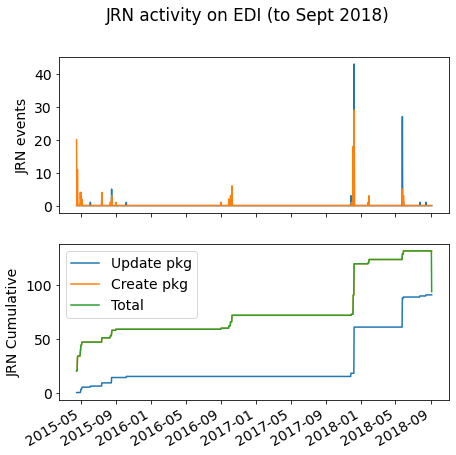

In [52]:
# All time plot:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 7), sharex=True)

ax[0].plot(rdEDI_early.index, rdEDI_early.n_update, label='Update pkg')
ax[0].plot(rdEDI_early.index, rdEDI_early.n_create, label='Create pkg')
ax[0].set_ylabel('JRN events')

ax[1].plot(rdEDI_early.index, rdEDI_early.n_update.cumsum(), label='Update pkg')
ax[1].plot(rdEDI_early.index, rdEDI_early.n_create.cumsum(), label='Create pkg')
ax[1].plot(rdEDI_early.index, rdEDI_early.n_tot.cumsum(), label='Total')

plt.ylabel('JRN Cumulative')
fig.autofmt_xdate()
plt.suptitle('JRN activity on EDI (to Sept 2018)')
plt.legend()

import os
#fig.savefig(os.path.expanduser("~/GD_gmaurer.jrn.lter/IM_diagnostics/JRN_EDI_all_{0}.png".format(now)),
#            dpi=150)

### Total number of packages

In [53]:
print(rdEDI_early.n_tot.sum())
rdEDI_early.n_update.sum()

94


91

## Activity during proposal lead-up

Approx 2018-09-05 to 2020-02-20

In [54]:
# This is after the LTER probabtion shock and after some big 
# delete operations on EDI
proptime = np.logical_and(df.index > enddt, df.index < '2020-02-20')
rdEDI_late = dia.counts_to_daily(df.loc[proptime,:])
rdEDI_late.head()

,n_update,n_create,n_tot
date,,,
2018-10-10,0,1,1
2018-10-11,0,1,1
2018-10-12,0,4,4
2018-10-13,0,0,0
2018-10-14,0,0,0


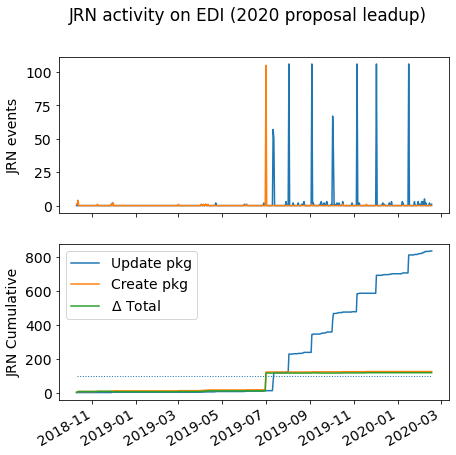

In [56]:
# Recent plot:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 7), sharex=True)

ax[0].plot(rdEDI_late.index, rdEDI_late.n_update, label='Update pkg')
ax[0].plot(rdEDI_late.index, rdEDI_late.n_create, label='Create pkg')
ax[0].set_ylabel('JRN events')

ax[1].plot(rdEDI_late.index, rdEDI_late.n_update.cumsum(), label='Update pkg')
ax[1].plot(rdEDI_late.index, rdEDI_late.n_create.cumsum(), label='Create pkg')
ax[1].plot(rdEDI_late.index, rdEDI_late.n_tot.cumsum(), label='$\Delta$ Total')
ax[1].hlines(y=100, xmin=rdEDI_late.index.min(), xmax=rdEDI_late.index.max(), ls=':', lw=1)

plt.ylabel('JRN Cumulative')
fig.autofmt_xdate()
plt.suptitle('JRN activity on EDI (2020 proposal leadup)')
plt.legend()

In [57]:
print(rdEDI_late.n_tot.sum())
rdEDI_late.n_update.sum()

117


836

### Late/early stats

In [58]:
print(rdEDI_late.n_tot.sum()/rdEDI_early.n_tot.sum())
print(rdEDI_late.n_update.sum()/rdEDI_early.n_update.sum())

1.2446808510638299
9.186813186813186


## Activity during proposal leadup, NOMET


In [38]:
# This is after the LTER probabtion shock and after some big 
# delete operations on EDI
rdEDI_lateNM = dia.counts_to_daily(df.loc[np.logical_and(proptime,df.studyid!='437'),:])
rdEDI_lateNM.head()

,n_update,n_create,n_tot
date,,,
2018-10-10,0,1,1
2018-10-11,0,1,1
2018-10-12,0,4,4
2018-10-13,0,0,0
2018-10-14,0,0,0


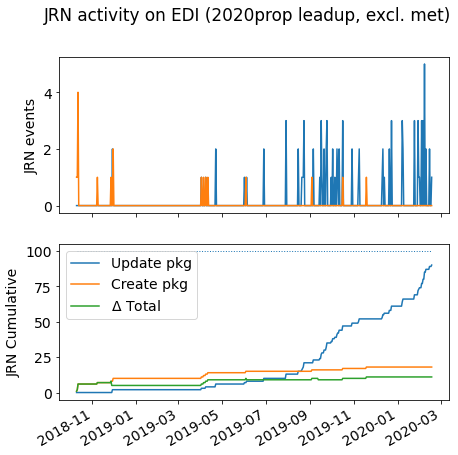

In [59]:
# Recent plot:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 7), sharex=True)

ax[0].plot(rdEDI_lateNM.index, rdEDI_lateNM.n_update, label='Update pkg')
ax[0].plot(rdEDI_lateNM.index, rdEDI_lateNM.n_create, label='Create pkg')
ax[0].set_ylabel('JRN events')

ax[1].plot(rdEDI_lateNM.index, rdEDI_lateNM.n_update.cumsum(), label='Update pkg')
ax[1].plot(rdEDI_lateNM.index, rdEDI_lateNM.n_create.cumsum(), label='Create pkg')
ax[1].plot(rdEDI_lateNM.index, rdEDI_lateNM.n_tot.cumsum(), label='$\Delta$ Total')
ax[1].hlines(y=100, xmin=rdEDI_lateNM.index.min(), xmax=rdEDI_lateNM.index.max(), ls=':', lw=1)

plt.ylabel('JRN Cumulative')
fig.autofmt_xdate()
plt.suptitle('JRN activity on EDI (2020prop leadup, excl. met)')
plt.legend()

In [60]:
print(rdEDI_lateNM.n_tot.sum())
rdEDI_lateNM.n_update.sum()

11


90

### Late/early stats

In [61]:
print(rdEDI_lateNM.n_tot.sum()/rdEDI_early.n_tot.sum())
print(rdEDI_lateNM.n_update.sum()/rdEDI_early.n_update.sum())

0.11702127659574468
0.989010989010989


## New fig

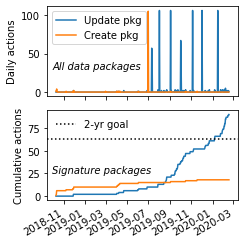

In [62]:
# Recent plot:
# Figure config
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}

matplotlib.rc('font', **font)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(3.5, 3.5), sharex=True)

ax[0].plot(rdEDI_late.index, rdEDI_late.n_update, label='Update pkg')
ax[0].plot(rdEDI_late.index, rdEDI_late.n_create, label='Create pkg')
ax[0].set_ylabel('Daily actions')
ax[0].text(.025, .3, 'All data packages', transform=ax[0].transAxes, style='italic')
ax[0].legend(loc="upper left")

ax[1].plot(rdEDI_lateNM.index, rdEDI_lateNM.n_update.cumsum())
ax[1].plot(rdEDI_lateNM.index, rdEDI_lateNM.n_create.cumsum())
#ax[1].plot(rdEDI_lateNM.index, rdEDI_lateNM.n_tot.cumsum(), label='$\Delta$ Total')
ax[1].axhline(y=63, xmin=0, xmax=1, ls=':', lw=1.5, color='k',
             label='2-yr goal')
ax[1].text(.025, .3, 'Signature packages', transform=ax[1].transAxes, style='italic')

plt.ylabel('Cumulative actions')
fig.autofmt_xdate()
#plt.suptitle('JRN activity on EDI, LTER-VII')
ax[1].legend(loc="upper left", framealpha=0)

plt.tight_layout()
#fig.savefig(os.path.expanduser(
#    "~/GD_gmaurer.jrn.lter/IM_figures/JRN_EDI_2020proposal.png".format(now)),
#            dpi=300)